# Classifier Training

## Common Imports and Settings

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import pytorch_lightning as pl
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200

/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.12. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.14
  warnings.warn(Warning(warning))


In [6]:
import yaml

with open("./config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
    
print(yaml.dump(config))

experiment_name: 'Old Settings: 224'
experiment_tags:
- CL
- Final
- New Settings
model_settings:
  BACKBONE_NUM_FTRS: 128
  BACKBONE_TYPE: resnet18
  INPUT_CHANNELS: 9
  PROJECTION_OUT_DIM: 128
neptune_project: fedorgrab/slide-seq-contrastive
optimizer:
  IS_SCHEDULED: true
  LEARNING_RATE: 0.001
  SCHEDULER_GAMMA: 0.995
  SCHEDULER_STEP_SIZE: 3
simulation:
  BATCH_SIZE: 128
  CROP_SIZE: 224
  INPUT_SIZE: 224
  MAX_EPOCHS: 2000
  NUMBER_OF_CHANNELS: 9
  N_CROPS_TEST_FOR_TISSUE: 1600
  N_ELEMENT_MIN: 1000
  PIXEL_SIZE: 4
  RANDOM_SEED: 1



# Load classifier data

In [113]:
classifier_data_folder = "../slide-seq-data"

train_classifier_1 = torch.load(os.path.join(data_folder, "train_data_for_classifier_1.pt"), map_location=torch.device('cpu'))                            
test_classifier_1 = torch.load(os.path.join(data_folder, "test_data_for_classifier_1.pt"), map_location=torch.device('cpu'))

train_classifier_2 = torch.load(os.path.join(data_folder, "train_data_for_classifier_2.pt"), map_location=torch.device('cpu')) 
test_classifier_2 = torch.load(os.path.join(data_folder, "test_data_for_classifier_2.pt"), map_location=torch.device('cpu')) 

print(len(train_classifier_1))
print(train_classifier_1[0].shape)

print(len(test_classifier_1))
print(test_classifier_1[0].shape)

print(len(train_classifier_2))
print(train_classifier_2[0].shape)

print(len(test_classifier_2))
print(test_classifier_2[0].shape)

3
torch.Size([12800, 128])
3
torch.Size([3840, 128])
3
torch.Size([12800, 128])
3
torch.Size([3840, 128])


## Define a training pipe helper function

Here we use a helper function

In [119]:
list(train_classifier_1[1])

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 ten

In [115]:
torch.bincount(train_classifier_1[1])

tensor([6400, 6400])

In [138]:
import lightly
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
from tissue_purifier.data_utils.dataset import SparseDataset
from tissue_purifier.data_utils.dataloader import DataLoaderWithLoad
from tissue_purifier.data_utils.transforms import SpecialCollateFn, StackTensor


def define_and_train_classifier(train_set, test_set, save_name, loss=None, batch_size=500, max_epochs=100):
    
    train_dataset = SparseDataset(x=train_set[0], y=train_set[1], z=list(train_set[2]))
    
    train_loader = DataLoaderWithLoad(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn = SpecialCollateFn(transform=StackTensor(dim=0)))

    test_dataset = SparseDataset(x=test_set[0], y=test_set[1], z=list(test_set[2]))
    
    test_loader = DataLoaderWithLoad(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn = SpecialCollateFn(transform=StackTensor(dim=0)))

    classifier = tp.model_utils.EmbeddingClassifier(
        embedding_out_dim=config["model_settings"]["BACKBONE_NUM_FTRS"], 
        out_dim=2, 
        loss=loss
    )
    
    gpus = 1 if torch.cuda.is_available() else 0
    trainer = pl.Trainer(max_epochs=max_epochs, gpus=gpus, progress_bar_refresh_rate=0, log_every_n_steps=1,)# logger=neptune_logger)
    trainer.fit(classifier, train_loader, test_loader)
    torch.save(classifier.state_dict(), save_name)
    # neptune_logger.experiment.log_artifact(save_name)
    return classifier, train_loader, test_loader

## Train Classifier 1: Test sample – 2; train samples – 1, 3

In [139]:
from tissue_purifier.loss_utils.loss_functions import NoisyLoss

In [140]:
classifier_1, train_loader_1, test_loader_1 = define_and_train_classifier(
    train_classifier_1, 
    test_classifier_1,
    save_name="classifier_1_fc.pt",
    loss=NoisyLoss(),
    max_epochs=40
)
# classifier_1 = tp.model_utils.EmbeddingClassifier(embedding_out_dim=NUM_FTRS, loss=None, out_dim=2, max_epochs=MAX_EPOCHS)
# classifier_1.load_state_dict(torch.load("./classifier_1_fc.pt"))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type      | Params
-----------------------------------
0 | fc   | Linear    | 258   
1 | loss | NoisyLoss | 0     
-----------------------------------
258       Trainable params
0         Non-trainable params
258       Total params
0.001     Total estimated model params size (MB)
/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [141]:
classifier_1

EmbeddingClassifier(
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (loss): NoisyLoss(
    (active_loss): FocalLoss()
    (passive_loss): ReversedCrossEntropyLoss()
  )
)

In [150]:
print(train_loader_1.dataset.x.shape)
print(len(train_loader_1.dataset.y))
print(len(train_loader_1.dataset.z))

torch.Size([12800, 128])
12800
12800


In [151]:
umap_embeddings = tp.evaluation_utils.get_umap(embeddings=train_loader_1.dataset.x, metric="euclidean", n_neighbors=15)
#pca_embeddings = tp.evaluation_utils.get_pca(embeddings=embeddings)
#tsne_embeddings = tp.evaluation_utils.get_tsne(embeddings=embeddings)

## Train Classifier 2: test sample – 1; train samples – 2, 3,

In [9]:
classifier_2 = define_and_train_classifier(
    (train_embeddings_2, train_labels_2), 
    (test_embeddings_2, test_labels_2),
    save_name="classifier_2_fc.pt",
    epochs=40
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | loss | CrossEntropyLoss | 0     
1 | fc   | Linear           | 258   
------------------------------------------
258       Trainable params
0         Non-trainable params
258       Total params
0.001     Total estimated model params size (MB)


## Get Masks based on what Neural Network Model Predicted

In [10]:
from tissue_purifier.model_utils import TrainedEmbedding

model_folder = "../trained_model"
model = tp.model_utils.helpers.define_model(
    backbone_type=config["model_settings"]["BACKBONE_TYPE"],
    number_of_channels=config["model_settings"]["INPUT_CHANNELS"],
    num_of_filters=config["model_settings"]["BACKBONE_NUM_FTRS"],
    projection_out_dim=config["model_settings"]["PROJECTION_OUT_DIM"],
)
model.backbone.load_state_dict(torch.load(f"./model.pth")["resnet18_parameters"])
# model.load_state_dict(torch.load(f"{model_folder}/simclr_model_11.pt"))
model = model.cuda()
encoder = TrainedEmbedding(model)

In [11]:
%%capture
classifier_1 = classifier_1.cuda()
mask_wt2 = tp.evaluation_utils.create_mask_for_sample(df_wt2, encoder, classifier_1, config, proba=True)
mask_dis2 = tp.evaluation_utils.create_mask_for_sample(df_dis2, encoder, classifier_1, config, proba=True)

In [12]:
df_dis2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis2, mask_dis2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt2, mask_wt2, pixel_size=config["simulation"]["PIXEL_SIZE"])

df_dis2["condition"] = df_dis2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)
df_wt2["condition"] = df_wt2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)

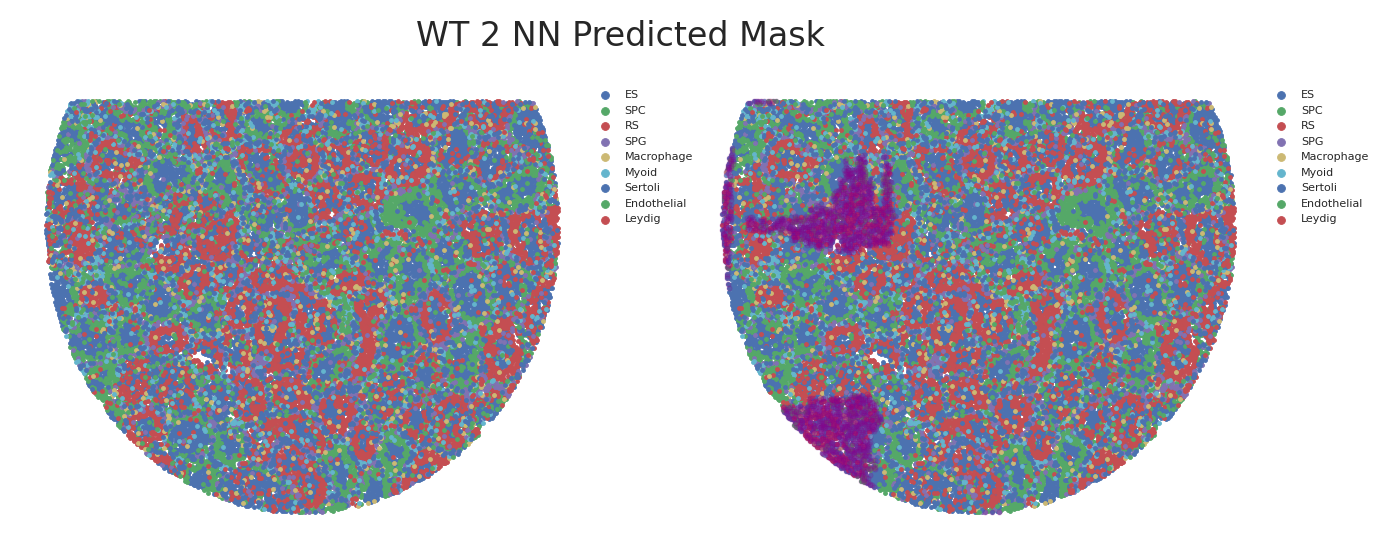

In [13]:
tp.plot_utils.disease_mask(df_wt2, "condition", figsize=(8, 3), title="WT 2 NN Predicted Mask")

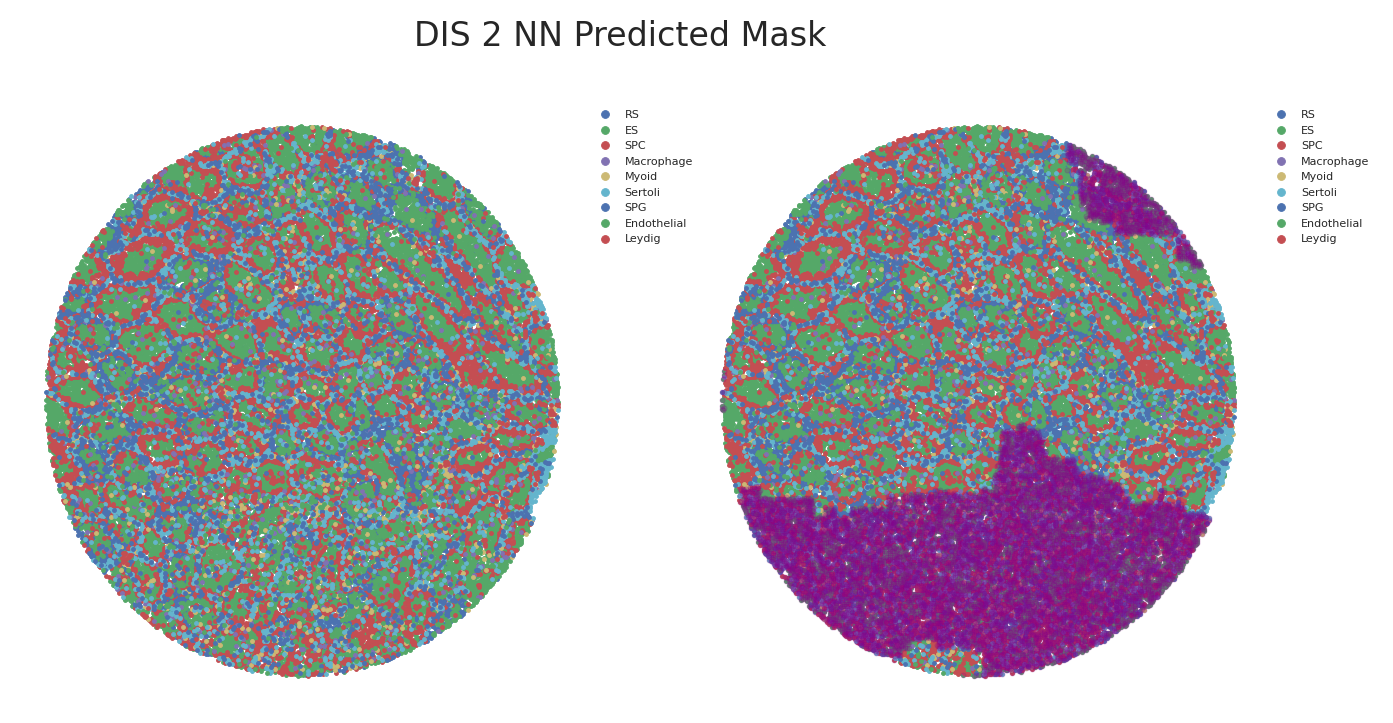

In [14]:
tp.plot_utils.disease_mask(df_dis2, "condition", figsize=(8, 4), title="DIS 2 NN Predicted Mask")

In [15]:
%%capture
classifier_2 = classifier_2.cuda()
mask_wt1 = tp.evaluation_utils.create_mask_for_sample(df_wt1, encoder, classifier_1, config, proba=True)
mask_dis1 = tp.evaluation_utils.create_mask_for_sample(df_dis1, encoder, classifier_1, config, proba=True)

In [16]:
df_wt1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt1, mask_wt1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis1, mask_dis1, pixel_size=config["simulation"]["PIXEL_SIZE"])

df_wt1["condition"] = df_wt1["nn_probas"].map(lambda x: 0 if x < 0.53 else 1)
df_dis1["condition"] = df_dis1["nn_probas"].map(lambda x: 0 if x < 0.66 else 1)

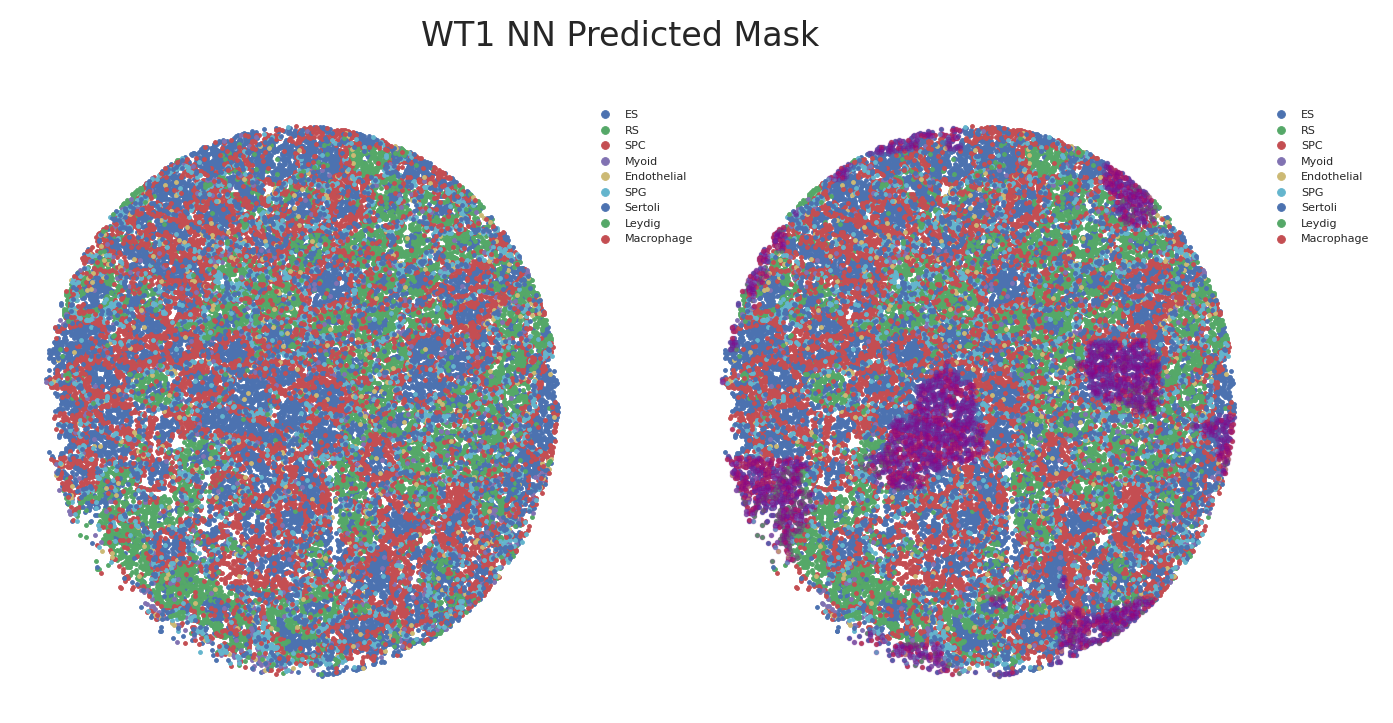

In [17]:
tp.plot_utils.disease_mask(df_wt1, "condition", figsize=(8, 4), title="WT1 NN Predicted Mask")

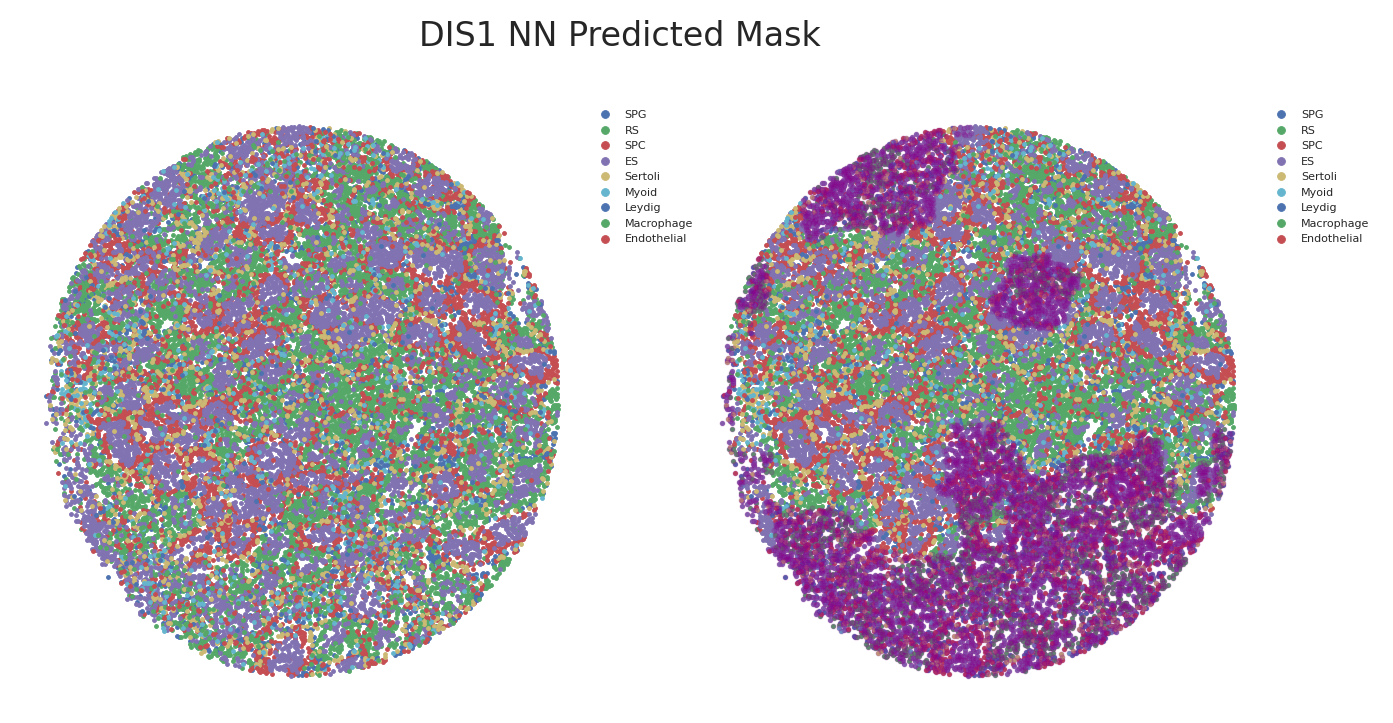

In [18]:
tp.plot_utils.disease_mask(df_dis1, "condition", figsize=(8, 4), title="DIS1 NN Predicted Mask")

## Moran's I Score Evaluation

[Moran's I Score](https://en.wikipedia.org/wiki/Moran's_I) is a measure of spatial autocorrelation developed by Patrick Alfred Pierce Moran

Calculate all Moran Score across 3 most abundant cell types for a dataframe with `condition` key

In [19]:
%%capture
moran_score_dis2 = tp.evaluation_utils.moran_score_tissue_conditions(df_dis2)

In [20]:
moran_score_dis2

total        WT       DIS
0  0.457191  0.502789  0.347304
1  0.421096  0.471087  0.318838
2  0.431585  0.474351  0.297061

Calculate Averaged Moran Score across 3 most abundant cell types in a list of dataframes

In [21]:
%%capture
moran_averaged = tp.evaluation_utils.moran_score_averaged(
    [df_wt1, df_wt2, df_dis1, df_dis2],
    ["WT1", "WT2", "DIS1", "DIS2"]
)

In [22]:
moran_averaged

total        WT       DIS
WT1   0.509587  0.510279  0.473267
WT2   0.487913  0.494517  0.381942
DIS1  0.452202  0.475495  0.394539
DIS2  0.436624  0.482743  0.321067